# Classifying Images of Everyday Objects

In this notebook we'll build a neural networks with many hidden layers to classify images of [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset. This dataset consists of 60,000 32x32 colour images in 10 classes, with 6,000 images per class. There are 50,000 training images and 10,000 test images.

The whole process of classifying is similar to the one of notebook [Training Deep Neural Networks on a GPU](deep%20neural%20networks%20with%20gpu.ipynb), except that the neural network class `Cifar10Model` has dynamique hidden layers, the number of hidden layers depends on the given hidden sizes.

We also use GPU to train model if available.

![CIFAR10](images/cifar10.svg)

## Import libraries

In [1]:
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt

## 1. Data

### 1.1 Download data

In [2]:
dataset = CIFAR10(root="data/", transform=ToTensor(), train=True, download=True)
test_ds = CIFAR10(root="data/", transform=ToTensor(), train=False)

Files already downloaded and verified


### 1.2 Explorer data

**Attributes & methods of the variable dataset**

In [3]:
# get all attributes
atts = [att for att in vars(dataset).keys() if not callable(vars(dataset)[att])]
print("dataset attributes: %s" % atts)
# get all methods
methods = [m for m in vars(dataset).keys() if callable(vars(dataset)[m])]
print("dataset methods: %s" % methods)

dataset attributes: ['root', 'target_transform', 'train', 'data', 'targets', 'classes', 'class_to_idx']
dataset methods: ['transform', 'transforms']


**Size of datasets**

In [4]:
# get dataset size
print("dataset size = {:,}".format(len(dataset)))
print("test set size = {:,}".format(len(test_ds)))

dataset size = 50,000
test set size = 10,000


**Output classes & output size**

In [5]:
# get output classes
classes = dataset.classes
print("output classes : %s" % classes)
print("output size = %s" % len(classes))

output classes : ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
output size = 10


**Shape of an image in dataset**

In [6]:
img, label = dataset[10]
print("image shape = %s" % list(img.shape))

image shape = [3, 32, 32]


label (numeric): 4
label (texture): deer


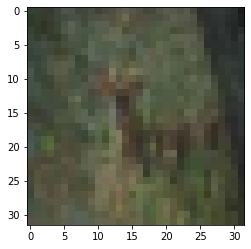

In [7]:
plt.imshow(img.permute((1, 2, 0)))
print("label (numeric): %s" % label)
print("label (texture): %s" % classes[label])

**Number of images in a class**

In [8]:
# get number of images in each class
cls_stats = dict(zip(classes, [0]*len(classes)))
for _, label in dataset:
    k = classes[label]
    cls_stats[k] += 1

In [9]:
for k, v in cls_stats.items():
    print("{}: {:,}".format(k, v))

airplane: 5,000
automobile: 5,000
bird: 5,000
cat: 5,000
deer: 5,000
dog: 5,000
frog: 5,000
horse: 5,000
ship: 5,000
truck: 5,000


**Show images in dataset**

In [10]:
images = list()
for i in range(128):
    img, _ = dataset[i]
    images.append(img)

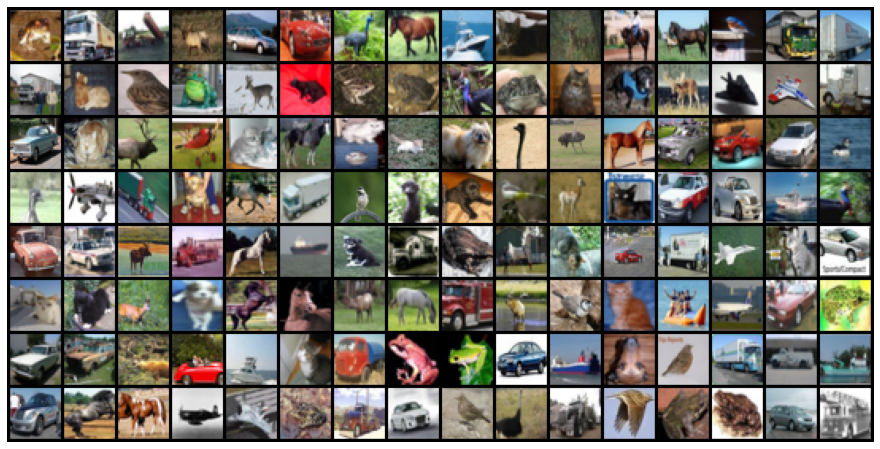

In [11]:
fig = plt.figure(figsize=(16,8))
plt.axis("off")
plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)));

### 1.3 Create datasets & data loaders

In [12]:
val_size = 5000
train_size = len(dataset) - val_size

In [13]:
torch.manual_seed(43)
train_ds, val_ds = random_split(dataset, [train_size, val_size])
print("training dataset size = {:,}".format(len(train_ds)))
print("validation dataset size = {:,}".format(len(val_ds)))

training dataset size = 45,000
validation dataset size = 5,000


In [14]:
batch_size = 128
train_loader = DataLoader(train_ds, batch_size, num_workers=4, pin_memory=True, shuffle=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size*3, num_workers=4, pin_memory=True)

## 2. Create Neural Network

Create a neural network of many layers. The number of hidden layers depends on the given hidden sizes.

In [15]:
class Cifar10Model(nn.Module):
    def __init__(self, in_features:int, out_classes:int, hidden_sizes:list):
        super().__init__()
        self.linear1 = nn.Linear(in_features, hidden_sizes[0])
        self.nb_hidden_layers = len(hidden_sizes)
        for i in range(self.nb_hidden_layers):
            func_name = "linear%s" % (i+2)
            if i+1 == self.nb_hidden_layers:
                func = nn.Linear(hidden_sizes[i], out_classes)
            else:
                func = nn.Linear(hidden_sizes[i], hidden_sizes[i+1])
            setattr(self, func_name, func)        
    
    def forward(self, X:torch.tensor) -> torch.tensor:
        """Compute linear prediction of image(s)
        
        Args:
            X (torch.tensor): input image(s)
            
        Returns:
            torch.tensor: linear prediction of image(s)
        """
        # flatten image
        X = X.reshape(-1, self.linear1.in_features)
        # compute activation units of hidden layers
        A = X
        for i in range(self.nb_hidden_layers):
            func = getattr(self, "linear%s" % (i+1))
            Z = func(A)
            A = F.relu(Z)
        # compute linear prediction
        func = getattr(self, "linear%s" % (self.nb_hidden_layers+1))
        Y_linear = func(A)
        return Y_linear
    
    def predict(self, X:torch.tensor) -> torch.tensor:
        """Predict class(es) of image(s)
        
        Args:
            X (torch.tensor): input image(s)
            
        Returns:
            torch.tensor: class(es) predicted
        """
        Y_linear = self(X)
        probs = F.softmax(Y_linear.detach(), dim=1)
        _, Y_hat = torch.max(probs, dim=1)
        return Y_hat
    
    def cost_func(self, batch:list) -> torch.tensor:
        """Compute cost of prediction(s)
        
        Args:
            batch (list): containing 2 values images & labels
            
        Returns:
            torch.tesor: the cost
        """
        images, labels = batch
        Y_linear = self(images)
        cost = F.cross_entropy(Y_linear, labels)
        return cost
    
    def evaluate(self, batch:list) -> dict:
        """Compute cost & accuracy of prediction(s)
        
        Args:
            batch (list): containing 2 values images & labels
        
        Returns:
            dict: containing 2 keys "cost" & "accuracy"
        """
        images, labels = batch
        Y_hat = self.predict(images)
        acc = torch.sum(Y_hat == labels).item()/len(Y_hat)
        Y_linear = self(images)
        cost = F.cross_entropy(Y_linear.detach(), labels).item()
        res = {
            "cost": cost,
            "accuracy": acc
        }
        return res

In [16]:
in_features = 3*32*32
out_classes = 10
hidden_sizes = [128, 128]

In [17]:
model = Cifar10Model(in_features, out_classes, hidden_sizes)

## 3. Using GPU

In [18]:
def getDefaultDevice():
    """Pick GPU if available, else CPU
    """
    if torch.cuda.is_available():
        return torch.device("cuda")
    return torch.device("cpu")

In [19]:
def toDevice(data, device:torch.device):
    """Move tensor(s) to chosen device
    
    Args:
        device (torch.device): device to move tensor(s) to
    """
    if isinstance(data, (list, tuple)):
        return [toDevice(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [20]:
class DeviceDataLoader():
    """This class is to wrap data loader and move batches of data
    to the selected device
    """
    def __init__(self, dataloader:DataLoader, device:torch.device):
        self.dataloader = dataloader
        self.device = device
    
    def __iter__(self):
        """This method is to retrieve batches of data
        """
        for batch in self.dataloader:
            yield toDevice(batch, self.device)
    
    def __len__(self):
        """This method is to get the number of batches
        """
        return len(self.dataloader)

Move model, data loaders to GPU if available

In [21]:
device = getDefaultDevice()
toDevice(model, device)
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

/home/tuanva/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [22]:
print("device used : %s" % device.type)

device used : cpu


## 4. Train model

In [23]:
def evaluateEpoch(batch_evals:list, decimals=3) -> dict:
    """Get cost & accuracy of predictions of an epoch
    
    Args:
        batch_evals (list): list of batch evaluations
        decimals (int, optional): decimals to round values
    
    Returns:
        dict: containing 2 keys "cost" & "accuracy"
    """
    batch_costs = [x["cost"] for x in batch_evals]
    batch_accs = [x["accuracy"] for x in batch_evals]
    cost = sum(batch_costs)/len(batch_costs)
    acc = sum(batch_accs)/len(batch_accs)
    res = {
        "cost": round(cost, decimals),
        "accuracy": round(acc, decimals)
    }
    return res

In [24]:
def fit(epochs:int, model:Cifar10Model, optimizer:torch.optim,
        train_loader:DataLoader, val_loader:DataLoader) -> list:
    """Train model
    
    Args:
        epochs (int): number of iterations
        model (Cifar10Model): model to train
        optimizer (torch.optim): function to optimize model parameters
        train_loader (DataLoader): data loader for training phase
        val_loader (DataLoader): data loader for validation phase
    
    Returns:
        list: evaluation results of epochs
    """
    logs = list()
    for i in range(epochs):
        # training phase
        for batch in train_loader:
            cost = model.cost_func(batch)
            cost.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # validation phase
        batch_evals = [model.evaluate(batch) for batch in val_loader]
        res = evaluateEpoch(batch_evals)
        logs.append(res)
        print("epoch %s: validation cost = %s, validation accuracy = %s" %
              (i+1, res["cost"], res["accuracy"]))
    return logs

In [25]:
epochs = 10
lr = 1e-1
optimizer = torch.optim.SGD(model.parameters(), lr)
logs = fit(epochs, model, optimizer, train_loader, val_loader)

epoch 1: validation cost = 1.844, validation accuracy = 0.332
epoch 2: validation cost = 1.899, validation accuracy = 0.312
epoch 3: validation cost = 1.777, validation accuracy = 0.368
epoch 4: validation cost = 1.792, validation accuracy = 0.35
epoch 5: validation cost = 1.701, validation accuracy = 0.386
epoch 6: validation cost = 1.766, validation accuracy = 0.37
epoch 7: validation cost = 1.554, validation accuracy = 0.448
epoch 8: validation cost = 1.762, validation accuracy = 0.371
epoch 9: validation cost = 1.613, validation accuracy = 0.44
epoch 10: validation cost = 1.555, validation accuracy = 0.436


In [26]:
epochs = 20
lr = 1e-2
optimizer = torch.optim.SGD(model.parameters(), lr)
logs += fit(epochs, model, optimizer, train_loader, val_loader)

epoch 1: validation cost = 1.442, validation accuracy = 0.49
epoch 2: validation cost = 1.44, validation accuracy = 0.49
epoch 3: validation cost = 1.434, validation accuracy = 0.492
epoch 4: validation cost = 1.43, validation accuracy = 0.493
epoch 5: validation cost = 1.424, validation accuracy = 0.498
epoch 6: validation cost = 1.423, validation accuracy = 0.497
epoch 7: validation cost = 1.425, validation accuracy = 0.495
epoch 8: validation cost = 1.421, validation accuracy = 0.494
epoch 9: validation cost = 1.418, validation accuracy = 0.496
epoch 10: validation cost = 1.418, validation accuracy = 0.493
epoch 11: validation cost = 1.417, validation accuracy = 0.495
epoch 12: validation cost = 1.412, validation accuracy = 0.495
epoch 13: validation cost = 1.412, validation accuracy = 0.498
epoch 14: validation cost = 1.425, validation accuracy = 0.498
epoch 15: validation cost = 1.421, validation accuracy = 0.506
epoch 16: validation cost = 1.409, validation accuracy = 0.504
epoch

### 4.1. Evaluation on validation set

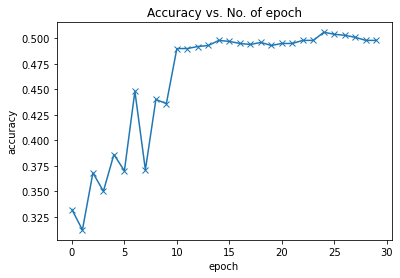

In [32]:
accuracies = [log['accuracy'] for log in logs]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title("Accuracy vs. No. of epoch")
plt.show();

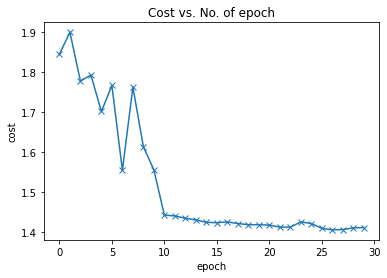

In [31]:
costs = [log['cost'] for log in logs]
plt.plot(costs, '-x')
plt.xlabel('epoch')
plt.ylabel('cost')
plt.title("Cost vs. No. of epoch")
plt.show();

### 4.2 Evaluation on test set

In [29]:
batch_evals = [model.evaluate(batch) for batch in test_loader]
res = evaluateEpoch(batch_evals)
print('test cost = {}, test accuracy = {}'.format(res['cost'], res['accuracy']))

test cost = 1.372, test accuracy = 0.512


### 4.3 Save model

In [30]:
torch.save(model.state_dict(), "cifar10.pth")